In [3]:
import os
# Suppress symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

from transformers import AutoModel, BertTokenizerFast, AdamW
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('../data/sentimental.csv')
print(df.head())
print(df.describe())

                                            sentence  label
0    Ok brokeback mountain is such a horrible movie.      0
1                 Brokeback Mountain was so awesome.      1
2  friday hung out with kelsie and we went and sa...      0
3  I am going to start reading the Harry Potter s...      1
4       Is it just me, or does Harry Potter suck?...      0
             label
count  5668.000000
mean      0.565279
std       0.495764
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


### Plot sentence lengths

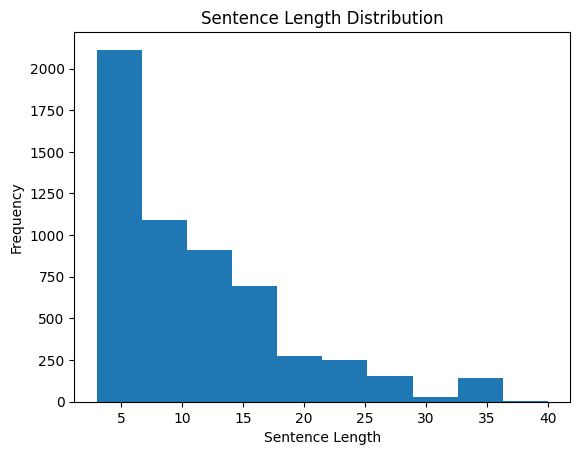

In [5]:
sentence_lengths = [len(sentence.split()) for sentence in df['sentence']]
plt.hist(sentence_lengths)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

### Load BERT model and tokenizer

In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

c:\Users\86176\torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Split Dataset

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['sentence'], df['label'], test_size=0.3, stratify=df['label'], random_state=2024 
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=0.5, stratify=temp_labels, random_state=2024
)

### Define padding length -> sentence length distribution

In [13]:
pad_len = 17

### Tokenize and encode sequences using BERT tokenizer

In [9]:
def encode_sentences(tokenizer, texts, max_length):
    return tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors='pt'
    )

In [14]:
tokens_train = encode_sentences(tokenizer, train_text, pad_len)
tokens_val = encode_sentences(tokenizer, val_text, pad_len)
tokens_test = encode_sentences(tokenizer, test_text, pad_len)

### Prepare torch for data loader

In [15]:
train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.values)

val_seq = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.values)

test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(test_labels.values)